# 1. Techniques for the generation of Cosmic Microwave Background maps

### Introduction from Jeff McMahon and Renée Hložek for the TMCL - CMB school 2019

The Cosmic Microwave Background (CMB) is the oldest observable light in the universe. As such it carries a wealth of cosmological information including: (1) signals from the early universe (primary anisotropy), and (2) distortions imprinted as this light propagates through the universe and encounters collapsed structures (secondary anisotropy).  Measurements of these signals give us important measurements and constraints on inflationary parameters, dark energy, dark matter, the sum of the neutrino masses, and many astrophysical processes.  The development of CMB instruments and analysis techniques is rapidly evolving.

This notebook provides an introduction to analysis techniques for CMB maps as they pertain to high resolution CMB instruments such as the Atacama Cosmology Telescope (ACT) and the South Pole Telescope (SPT).  These state of the art instruments have thousands of detectors (pixels) deployed on 6 and 10 meter telescopes which produce arc minute resolution beams at 150 GHz.  These telescopes observe by scanning across the sky.  The data from each detector are read out at high speed (typically > 50 Hz) to produce 'detector time streams' which are recored along with pointing information and other ancillary data.  Sophisticated codes are used to convert these time streams into maps of the CMB sky.  These maps can have correlated noise that must be accounted for in data analysis.   The mapmaking algorithms are not described here but represent a very interesting big data challenge as they require cleaning time streams by filtering, identifying transient events, and ultimately compressing ~Tb of data down to maps that are typically 100 Mb or less.  

Here are example maps from SPT (top, taken from a phys.org article from April 2, 2012 titled "South Pole Telescope hones in on dark energy, neutrinos") and ACTPol (bottom, taken from the Naess et al. 2014 CMB polarization paper).  Many features are obvious in these maps including: (1) the primary CMB visible as waves in the intensity, (2) active galactic nuclei and other bright astrophysical point sources which manifest as bright dots, (3) clusters of galaxies which show up as darkened point sources, and (4) horizontal stripes (in the SPT map) that are the result of the noise and map filtering.  The ACTPol figure shows multiple maps; the T is temperature, Q and U are polarization, and E and B are also polarization but decomposed into a basis such that the E is the amplitude of the curl-free component, and B is the amplitude of the divergence free component of the polarization vector field.


![cosmo_img](./img/newcosmology.jpg "Cosmology")

![cmb_maps](./img/maps_b.png "CMB")

While the current instruments (ACTPol and SPTPol) have multiple frequencies and polarization sensitivity, for simplicity we consider only a single frequency (150 GHz) and only temperature.  Adding extra frequency channels or polarization add the cost of slightly more work and would make this presentation more confusing.  Therefore we leave these complications for a future treatment and focus on temperature alone.  This allows us to show the basics of monty carlo analysis of both the angular power spectrum and matched filter techniques for studying Sunyaev-Zeldovich (SZ) effect.

The short course is organized as follows.   We beginning by building simulation of the CMB sky including the primary CMB, point sources (AGN and dusty galaxies), the SZ effect, and (if time) CMB lensing.   To these maps, we fold in instrumental effects including the beam, instrument and atmospheric noise.  We then present several analysis techniques including monty carlo estimation of power spectra and matched filter techniques for extraction of sources    An example of a stacking analysis is presented as an example of a cross-correlation with external data sets.  Cross-correlation is a very active field of research.

In the interest of simplicity we use approximate distributions for source and SZ counts with combinations of exponential and poisson distributions.   We note explicitly where we make these approximations.

## Code preliminaries

In [1]:
import os
import sys
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
data = './data/'
out = './output/'

### Just some matplotlib and seaborn parameter tuning

In [3]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## Section 1.1: Angular Power Spectrum
The majority of the information content of the CMB is contained in its angular power spectrum.   This spectrum is the amplitude squared of the magnitude of the temperature fluctuations as a function of $\ell$.  Here $\ell$ is the variable you have seen before with the spherical harmonics (e.g., $Y_{\ell m}$).  $\ell = 0$ corresponds to a constant temperature across the sky, $\ell = 200$ corresponds approximately to scales of $1^\circ$.  For a given set of input cosmological parameters these spectra can be computed with codes including CMBFAST or the more modern equivalent CAMB.  The spectrum used below was computed with CAMB web interface on NASA's LAMBDA interface.

http://lambda.gsfc.nasa.gov/toolbox/tb_camb_form.cfm

It is fun to play with parameters and see how the spectrum changes. 

The relative locations and amplitudes of the peaks carry a great deal of information.  The location of the first peak at $\ell \sim 200$ provided the first definitive measurement that our universe is flat.  The shape of the spectrum constraints a wide variety of cosmological parameters including dark energy and dark matter.  The fall off at high ell (e.g. $\ell \gtrsim 1000$ is called the damping tail and it provides constrains on the spectral index from inflation.  A wealth of cosmological parameters are constrained by measurements of this spectrum.  

At this point the temperature spectrum is well measured and the open frontiers are polarization and secondary anisotropies that are not included in this spectrum.   We will now build simulated skies including the CMB anisotropy and secondary anisotropies.  After that we will show how to estimate the power spectrum from map data using monte carlo techniques.   This monty carlo approach can be used for interpretation of polarization data and for the interpretation of cross-correlations between CMB and other survey data.

Here is how to read in an plot the CMB temperature spectrum from a CAMB simulation.

In [4]:
# Read in the input CMB spectra
d = np.genfromtxt(data + 'CAMB_fiducial_cosmo_scalCls.dat')
ell = d[:,0]
DlTT = d[:,1]
ell_err = d[:,2]
DlTT_err = d[:,3]

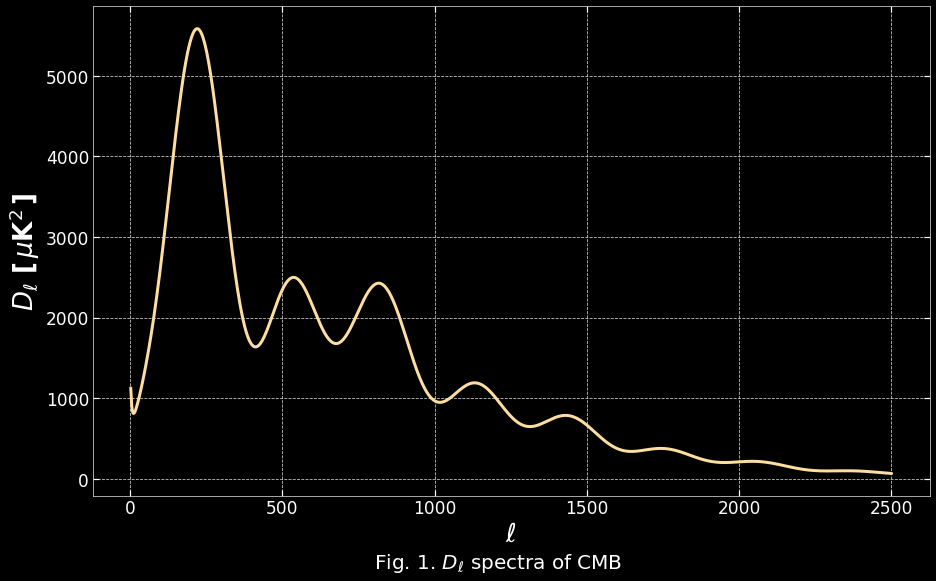

In [5]:
fig, axes = plt.subplots(figsize=(15, 9),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
cut = 2500
axes.plot(ell[:cut], DlTT[:cut],
          color=cm.magma(0.93), lw=3)

axes.set_xlabel('$\ell$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('$D_{\ell}$ [$\,\mu$K$^2\,$]', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

fig.suptitle('Fig. 1. $D_{\ell}$ spectra of CMB',
             color='white', fontsize=axistitlesize, y=0.04)

plt.savefig(out + 'cmb_angular_spectrum.png',
            format='png', dpi=200,
            facecolor='black', edgecolor='black',
            bbox_inches='tight')

plt.show()

This plot is the angular power spectrum of the CMB temperature anisotropies. It is traditional to plot $D_\ell$ which give the variance on varius angular scales. This is related to the angular power spectrum $C_\ell$ by

$$
D_\ell = \frac {\ell (\ell+1)} {2 \pi} C_\ell.
$$

The correct thing to use for creating CMB maps is $C_\ell$, but $D_\ell$ is what you are used to seeing plotted.

Interesting <font color='red'> EXCERCISE</font> from the original CMB school notebooks: Go to the NASA LAMBDA CAMB web interface and generate a power spectrum for a for a model universe with a strange component of your choosing (e.g., with spatial curvature, no dark energy, some other bizare component). Make a plot comparing this power spectrum to the vanilla spectrum above.

In [6]:
# Read in the input CMB spectra
d = np.genfromtxt(data + 'camb_36853880_scalcls.dat')
ell_strange = d[:,0]
DlTT_strange = d[:,1]

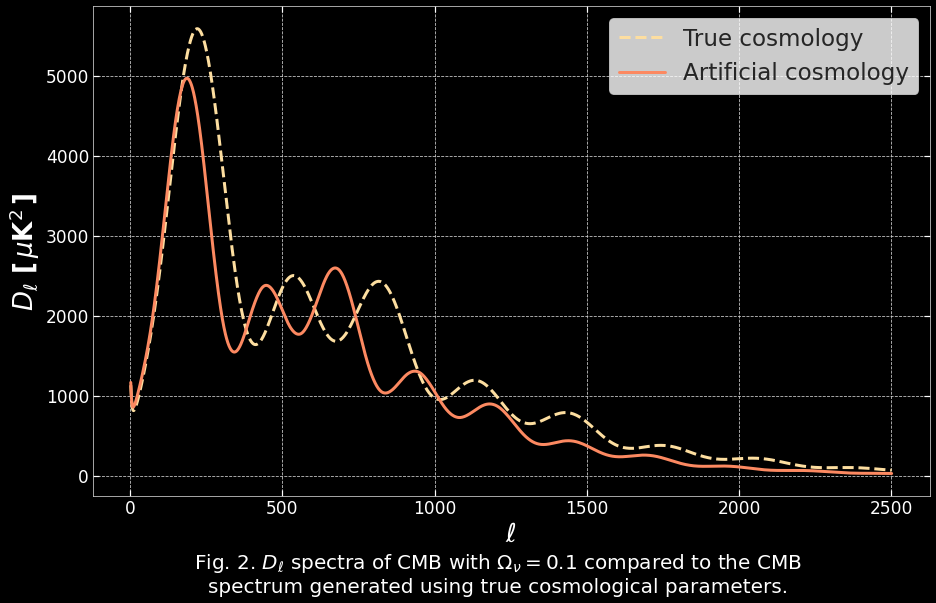

In [7]:
fig, axes = plt.subplots(figsize=(15, 9),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
cut = 2500
axes.plot(ell[:cut], DlTT[:cut], label='True cosmology',
          color=cm.magma(0.93), lw=3, ls='--')
axes.plot(ell_strange[:cut], DlTT_strange[:cut], label='Artificial cosmology',
          color=cm.magma(0.75), lw=3)

axes.set_xlabel('$\ell$', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('$D_{\ell}$ [$\,\mu$K$^2\,$]', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

axes.legend(loc='upper right', fontsize=axislegendsize)

fig.suptitle('Fig. 2. $D_{\ell}$ spectra of CMB with $\\Omega_{\\nu} = 0.1$ compared to the CMB\n' +
             'spectrum generated using true cosmological parameters.',
             color='white', fontsize=axistitlesize, y=0.04)

plt.savefig(out + 'cmb_angular_spectrum.png',
            format='png', dpi=200,
            facecolor='black', edgecolor='black',
            bbox_inches='tight')

plt.show()

## Section 1.2: Temperature Anisotropy Map
In this step we generate a simulated map of the CMB sky with the spectrum we read in above.  Since the power spectrum is a function of $\ell$ we need to do much of the work in harmonic space.  If we were generating a map on the full sky we would need to work with spherical harmonics.  Here we consider a small patch of sky ($\sim 10^\circ \times 10^\circ$) were we cam is the 'flat-sky' approximation and replace $\ell$ with $k = \sqrt{k_{x}^{2} + k_{y}^{2}}$.  There is a linear dependance between these variables defined by $\ell = k \cdot 2 \pi$.

In the flat sky approximation we generate a CMB map by:
    
    (1) generating a 2D power spectrum by revolving the above spectrum (properly normalized) about the axis in polar coordinates,
    (2) generating a Gaussian random map with unit variance as our 'random realisation',
    (3) multiplying that maps from 1 and 2, and
    (4) Fourier transforming this to get a real space map.

We provide a function to do this and a function to plot this (and other maps) with a uniform color scale.

In [8]:
# Variables to set up the size of the map
## Number of pixels in the longer linear dimension.
## Since we are using lots of FFTs this should be a factor of 2^N
N = 2**10
# Variables to set up the map plots
c_min = -400     # Minimum for color bar
c_max = 400      # Maximum for color bar
X_width = 8      # Horizontal map width in degrees
Y_width = 8      # Vertical map width in degrees

# Pixel number along axes
N_x = N if X_width > Y_width else N // (Y_width//X_width)
N_y = N if X_width < Y_width else N // (X_width//Y_width)
pix_size  = (X_width/N_x) * 60 # Size of a pixel in arcminutes

In [9]:
def haversine(X, Y):
    """
    Calculates the Haversine formula for every gridpoint on a given domain.
    
    Parameters
    ----------
    X : numpy.ndarray of shape(N_x, N_y)
        X coordinates of the domain.
    Y : numpy.ndarray of shape(N_x, N_y)
        Y coordinates of the domain.
    
    Returns
    -------
    R : numpy.ndarray of shape(N_x, N_y)
        Distance matrix of the grid of the input domain.
    """
    R = 2 * np.arcsin(np.sqrt(np.sin(X/2)**2 + np.cos(X) * np.sin(Y/2)**2))
    
    return R

In [10]:
def make_coordinates(N_x=2**10, N_y=2**10//2,
                     X_width=360, Y_width=180,
                     absolute=False):
    """
    Make an "absolute" or "relative", 2D equirectangular coordinate system.
    
    Parameters
    ----------
    N_x : int
        Number of pixels in the linear dimension along the X-axis.
    N_y : int
        Number of pixels in the linear dimension along the Y-axis.
    X_width : float
        Size of the map along the X-axis in degrees.
    Y_width : float
        Size of the map along the Y-axis in degrees.
        
    Returns
    -------
    R : numpy.ndarray of shape (N_x, N_y)
        The distance matrix over the generated domain.
    """
    
    if absolute:
        x = np.linspace(-np.deg2rad(X_width)/2, np.deg2rad(X_width)/2, N_x)
        y = np.linspace(-np.deg2rad(Y_width)/2, np.deg2rad(Y_width)/2, N_y)
    else:
        x_short = True if N_x < N_x else False
        prop = N_y/N_x if x_short else N_x/N_y
        base = np.linspace(-0.5, 0.5, (N_x if x_short else N_y))
        long = np.linspace(-0.5*prop, 0.5*prop, (N_y if x_short else N_x))
        x = base if x_short else long
        y = long if x_short else base
    X, Y = np.meshgrid(x, y)
    # Calculating the distance matrix of a grid on a spherical surface using
    # the Haversine formula
    R = haversine(X, Y)
    
    # The haversine formula above gives us distances on the surface of the sphere,
    # which are dependent of the radius of the sphere in question.
    # To make them independent of this quantity (which is completely incomprehensible
    # in case of the CMB), we need to convert these values to angles. Since we're
    # working with arcminutes everywhere in this project, I'll convert them
    # to arcmins.
    # Sometimes only the proportions needed, but sometimes the arcmins itself.
    if absolute:
        R = np.rad2deg(R) * 60
    
    return R

In [11]:
def make_CMB_I_map(ell, DlTT,
                   N_x=2**10, N_y=2**10//2,
                   X_width=360, Y_width=180, pix_size=0.5,
                   random_seed=None):
    """
    Makes a realization of a simulated CMB sky map given an input :math:`D_{\ell}` as a function
    of :math:`\ell`. This routine creates a 2D :math:`\ell` and :math:`C_{\ell}` spectrum and
    generates a Gaussian, random realization of the CMB in Fourier space using these. At last the
    map is converted into Image space, which will result us a randomly generated intensity map of
    the CMB temperature anisotropy. 
    
    Parameters
    ----------
    ell : numpy.array or array-like
        List of multipoles for which the angular power spectrum values
        were evaluated. Contains integers from 2 to :math:`l_{\mathrm{max}}`,
        where :math:`l_{\mathrm{max}}` is included.
    DlTT : numpy.array or array-like
        Transformed angular power spectrum bins (:math:`D_{l}`) for every
        multipole value in `ell`. The transformation is
        .. math::
                    D_{l} = \frac{l (l + 1)}{2 \pi} C_{l}.
    N_x : int
        Number of pixels in the linear dimension along the X-axis.
    N_y : int
        Number of pixels in the linear dimension along the Y-axis.
    X_width : float
        Size of the map along the X-axis in degrees.
    Y_width : float
        Size of the map along the Y-axis in degrees.
    pix_size : float
        Size of a pixel in arcminutes.
    random_seed : float
        Sets the random seed for `numpy`'s Mersenne Twister pseudo-random number generator.
        
    Returns
    -------
    CMB_I : numpy.ndarray of shape (N_x, N_y)
        The generated intensity map of the CMB temperature anisotropy in Image space.
    ell2d : numpy.ndarray of shape (N_x, N_y)
        2D spectrum of the :math:`\ell` values.
    ClTT2d : numpy.ndarray of shape (N_x, N_y)
        2D realization of the :math:`C_{\ell}` power spectrum in Image space.
    FT_2d : numpy.ndarray of shape (N_x, N_y)
        Randomly generated Gaussian map in Fourier space.
    """
    # Convert Dl to Cl
    ClTT = DlTT * 2 * np.pi / (ell * (ell + 1))
    # Set the monopole and the dipole of the Cl spectrum to zero
    ClTT[0] = 0
    ClTT[1] = 0

    # Calculate distances to the center of the image on the map
    R = make_coordinates(N_x, N_y,
                         X_width, Y_width,
                         absolute=False)

    # Now make a 2D CMB power spectrum
    pix_to_rad = np.deg2rad(pix_size/60)       # Going from `pix_size` in arcmins to radians
    ell_scale_factor = 2 * np.pi / pix_to_rad  # Now relating the angular size in radians to multipoles
    ell2d = R * ell_scale_factor               # Making a fourier space analogue to the real space `R` vector

    # Making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D `ell` vector
    # if the latter is shorter, than the `ell2d` vector
    _THRES = int(ell2d.max()) + 1
    if _THRES > ClTT.size:
        ClTT_expanded = np.zeros(int(ell2d.max()) + 1) 
        ClTT_expanded[0:(ClTT.size)] = ClTT        # Fill in the Cls until the max of the `ClTT` vector
    else:
        ClTT_expanded = ClTT

    # The 2D Cl spectrum is defined on the multiple vector set by the pixel scale
    ClTT2d = ClTT_expanded[ell2d.astype(int)] 
    
    # Now make a realization of the CMB with the given power spectrum in real space
    ## Generate a Gaussian random CMB map in Fourier space
    np.random.seed(random_seed)
    random_array_for_T = np.random.normal(0, 1, (N_y, N_x))
    FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # Take FFT since we are in Fourier space
    FT_2d = np.sqrt(ClTT2d) * FT_random_array_for_T           # We take the sqrt since the power spectrum is T^2
    
    ## Converting the random map to real space
    # Move back from ell space to real space
    CMB_I = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
    # Move back to pixel space for the map
    CMB_I /= (pix_size /60 * np.pi/180)
    # We only want to plot the real component
    CMB_I = np.real(CMB_I)

    return(CMB_I, ell2d, ClTT2d, FT_2d)

In [12]:
def planck_cmap():
    """
    Generates the Planck CMB colormap from an input file, which stores the color values
    for the complete gradient. The colormap values was obtained from the following link:
    - https://github.com/zonca/paperplots/raw/master/data/Planck_Parchment_RGB.txt
    """
    cmap = ListedColormap(np.loadtxt(data + 'Planck_Parchment_RGB.txt')/255.)
    cmap.set_bad('black')   # color of missing pixels
    cmap.set_under('white') # color of background
    
    return cmap

In [13]:
def plot_CMB_map(CMB_I, X_width, Y_width,
                 cmap=None, c_min=-400, c_max=400,
                 save=False, save_filename='default_name_cmb',
                 no_axis=False, no_grid=True):
    """
    Plots the generated rectangular intensity map of the CMB temperature anisotropy.
    
    Parameters
    ----------
    CMB_I : numpy.ndarray of shape (N_x, N_y)
        The generated intensity map of the CMB temperature anisotropy in real space.
    X_width : float
        Size of the map along the X-axis in degrees.
    Y_width : float
        Size of the map along the Y-axis in degrees.
    cmap : str or a matplotlib.colors.* colormap
        The colormap used to shade the pixels. By default the routine uses the classic Planck CMB
        colormap.
    c_min : float
        The lower limit for plotted values. All values of the input matrix below this limit will be
        scaled up to this value.
    c_max : float
        The upper limit for plotted values. All values of the input matrix below this limit will be
        scaled up to this value.
    save : bool
        If `True`, then saves the image into the output folder, under the name `save_filename`.
    no_axis : bool
        If `True`, then the axis labels and ticks will be hidden.
    no_grid : bool
        If `True`, then the gridlines will be hidden.
    """
    fig, axes = plt.subplots(figsize=(12,12),
                             facecolor='black', subplot_kw={'facecolor' : 'black'})
    axes.set_aspect('equal')
    if no_axis : axes.axis('off')
    if no_grid : axes.grid(False)
    
    # Convert 'CMB_I' to display properly
    _map = CMB_I.copy()
    _map[CMB_I < c_min] = c_min
    _map[CMB_I > c_max] = c_max
    
    # Set colormap for the image
    colormap = planck_cmap() if cmap is None else cmap

    im = axes.imshow(_map,
                     cmap=colormap, vmin=c_min, vmax=c_max,
                     interpolation='bilinear', origin='lower')
    im.set_extent([-X_width/2,X_width/2, -Y_width/2,Y_width/2])
    
    axes.set_title('map mean : {0:.3f} | map rms : {1:.3f}'.format(np.mean(CMB_I), np.std(CMB_I)),
                   color='white', fontsize=axistitlesize, fontweight='bold', pad=10)
    axes.set_xlabel('Angle $[^\circ]$', color='white', fontsize=axislabelsize, fontweight='bold')
    axes.set_ylabel('Angle $[^\circ]$', color='white', fontsize=axislabelsize, fontweight='bold')
    axes.tick_params(axis='both', which='major', colors='white', labelsize=axisticksize, labelrotation=42, pad=10)
    
    # Create an axis on the right side of `axes`. The width of `cax` will be 2%
    # of `axes` and the padding between `cax` and axes will be fixed at 0.1 inch
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='2%', pad=0.1)
    cbar = plt.colorbar(mappable=im, cax=cax)#, shrink=0.735, pad=0.02)
    cbar.ax.tick_params(labelsize=axiscbarfontsize, colors='white')
    cbar.set_label('Temperature [$\mu$K]', color='white',
                   fontsize=axiscbarfontsize+8, rotation=90, labelpad=12)

    if save:
        if not os.path.exists(out):
            os.makedirs(out)
        f = save_filename.split('.')
        fn = f[0]
        ff = 'png' if len(f) == 1 else f[1]
        plt.savefig(out + fn + '.' + ff,
                    format=ff, dpi=200,
                    facecolor='black', edgecolor='black',
                    bbox_inches='tight')
    plt.show()

In [14]:
def plot_CMB_steps(ell2d, ClTT2d, CMB_2D,
                   X_width, Y_width,
                   no_axis=False, no_grid=True):
    """
    Plots the 2D :math:`C_{l}` power spectrum in Image space, and the real part
    of it in Fourier space.
    
    Parameters
    ----------
    ell2d : numpy.ndarray of shape (N_x, N_y)
        2D spectrum of the :math:`\ell` values.
    ClTT2d : numpy.ndarray of shape (N_x, N_y)
        2D realization of the :math:`C_{\ell}` power spectrum in Image space.
    CMB_2D : numpy.ndarray of shape (N_x, N_y)
        The randomly generated CMB map in 2D Fourier space, calculated using the
        originally created random 2D Gaussian map.
    X_width : float
        Size of the map along the X-axis in degrees.
    Y_width : float
        Size of the map along the Y-axis in degrees.
    no_axis : bool
        If `True`, then the axis labels and ticks will be hidden.
    no_grid : bool
        If `True`, then the gridlines will be hidden.
    """
    nrows = 2
    ncols = 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*12, nrows*12))
    fig.subplots_adjust(hspace=0.20)
    
    titles = ['Log. of the 2D $C_{\ell}$ spectrum in Image space',
              'Real part of the 2D $C_{\ell}$ spectrum in Fourier space']
    labels = ['Angle $[^\circ]$',
              'Multipoles $(\ell)$']
    
    ### PLOT 1. -- Logarithm of the 2D Cl spectrum
    ax = axes[0]
    ax.set_aspect('equal')
    if no_axis : ax.axis('off')
    if no_grid : ax.grid(False)

    ## Set 0 values to the minimum of the non-zero values to avoid `ZeroDivision error` in `np.log()`
    ClTT2d[ClTT2d == 0] = np.min(ClTT2d[ClTT2d != 0]) 
    im_1 = ax.imshow(np.log(ClTT2d), vmin=None, vmax=None,
                     interpolation='bilinear', origin='lower', cmap=cm.RdBu_r)
    im_1.set_extent([-X_width/2,X_width/2, -Y_width/2,Y_width/2])
    ## Create an axis on the right side of `axes`. The width of `cax` will be 5%
    ## of `axes` and the padding between `cax` and axes will be fixed at 0.1 inch
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.1)
    cbar = plt.colorbar(mappable=im_1, cax=cax)
    cbar.ax.tick_params(labelsize=axiscbarfontsize, colors='black')
    cbar.ax.yaxis.get_offset_text().set(size=axiscbarfontsize)
    cbar.set_label('Log-temperature [$\mu$K]', fontsize=axiscbarfontsize+8, rotation=90, labelpad=19)
    
    ### PLOT 2. -- 2D CMB map in Fourier space
    ax = axes[1]
    ax.set_aspect('equal')
    if no_axis : ax.axis('off')
    if no_grid : ax.grid(False)
    
    im_2 = ax.imshow(CMB_2D, vmin=0, vmax=np.max(np.conj(FT_2d) * FT_2d * ell2d * (ell2d + 1) / (2 * np.pi)).real,
                     interpolation='bilinear', origin='lower', cmap=cm.RdBu_r)
    ext = ell2d.max()   # Upper border of the extent of the whole map
    im_2.set_extent([-ext, ext, -ext, ext])
    
    lim = int(ext / 3)  # Limit to be plotted
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    
    ## Set ticks and ticklabels
    ticks = np.linspace(-lim, lim, 11)
    ticklabels = np.array(['{0:.0f}'.format(t) for t in ticks])
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)
    
    ## Create an axis on the right side of `axes`. The width of `cax` will be 5%
    ## of `axes` and the padding between `cax` and axes will be fixed at 0.1 inch
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.1)
    cbar = plt.colorbar(mappable=im_2, cax=cax)
    cbar.ax.tick_params(labelsize=axiscbarfontsize, colors='black')
    cbar.ax.yaxis.get_offset_text().set(size=axiscbarfontsize)
    cbar.set_label('Frequency', fontsize=axiscbarfontsize+8, rotation=90, labelpad=19)
    
    for i in range(nrows):
        ax = axes[i]
        
        ax.set_title(titles[i], fontsize=axistitlesize, fontweight='bold')
        ax.set_xlabel(labels[i], fontsize=axislabelsize, fontweight='bold')
        ax.set_ylabel(labels[i], fontsize=axislabelsize, fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=axisticksize, rotation=42, pad=10)
    
    plt.show()

In [15]:
CMB_I, ell2d, ClTT2d, FT_2d = make_CMB_I_map(ell, DlTT, N_x=N_x, N_y=N_y,
                                             X_width=X_width, Y_width=Y_width, pix_size=pix_size,
                                             random_seed=42)

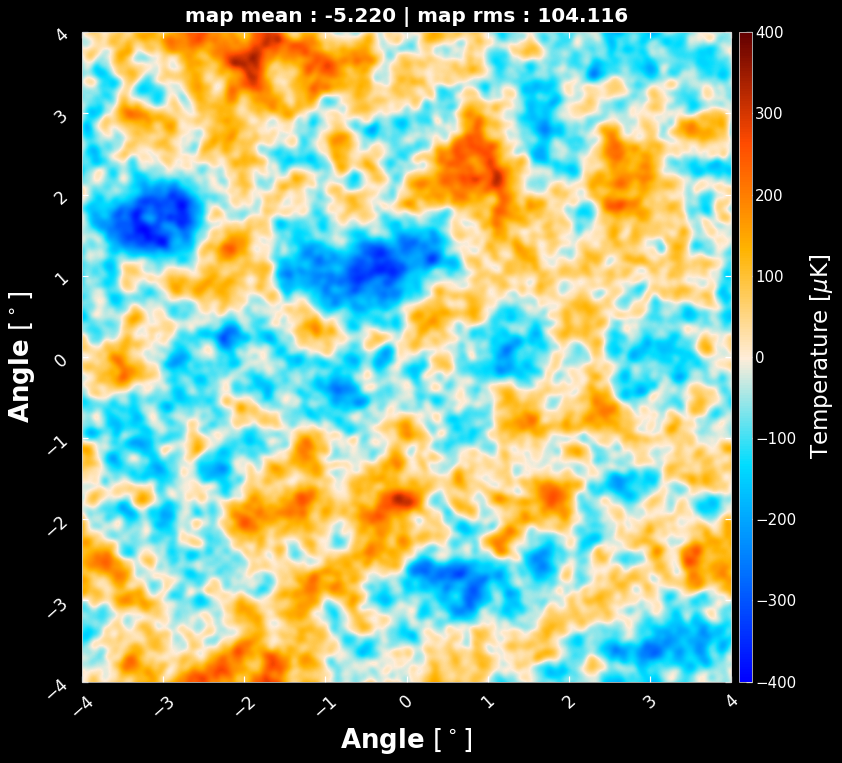

In [16]:
plot_CMB_map(CMB_I, X_width, Y_width, c_min=c_min, c_max=c_max,
             save=False, save_filename='CMB_I_map_gen.png',
             no_axis=False, no_grid=True)

This contour plot shows simulated CMB map we just generated.  If you generate it multiple times you will find that you get different patterns, however you will see that the typical size of the brightest and darkest spots will stay around $1^\circ$, corresponding to the peak of the angular power spectrum.  All simulated sky maps are displayed with the same color scale to permit visual comparison.

In [17]:
# Create the the 2D CMB simulated map in Fourier space, note the x and y axis labels need to be fixed
CMB_2D = np.real(np.conj(FT_2d) * FT_2d*ell2d * (ell2d+1) / (2*np.pi))

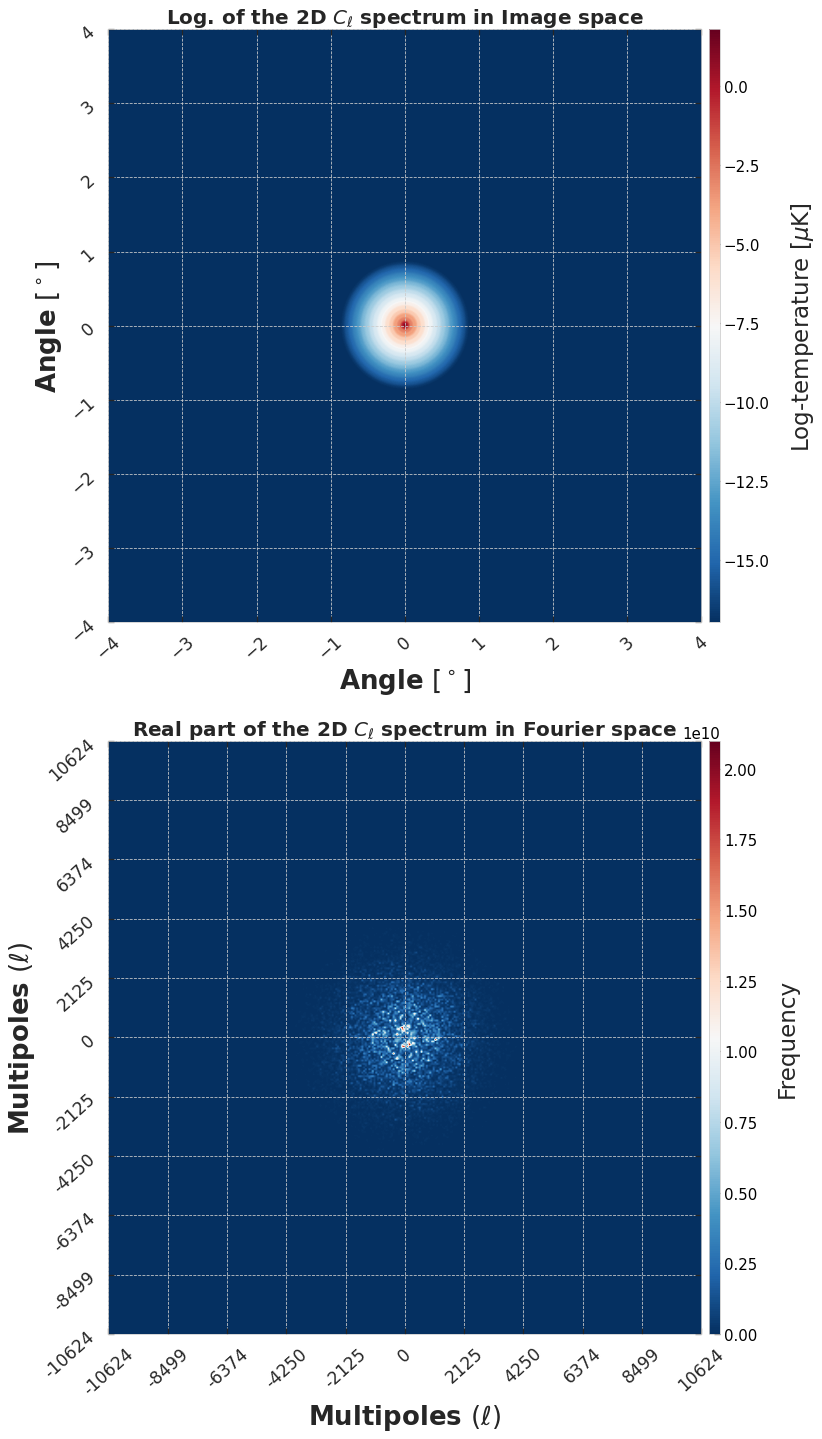

In [18]:
plot_CMB_steps(ell2d, ClTT2d, CMB_2D,
               X_width, Y_width,
               no_axis=False, no_grid=False)

### Cut spectrum below $\ell < 1000$

In [19]:
DlTT_cb = DlTT.copy()
DlTT_cb[ell < 1000] = 0
CMB_I, ell2d, ClTT2d, FT_2d = make_CMB_I_map(ell, DlTT_cb, N_x=N_x, N_y=N_y,
                                             X_width=X_width, Y_width=Y_width, pix_size=pix_size)

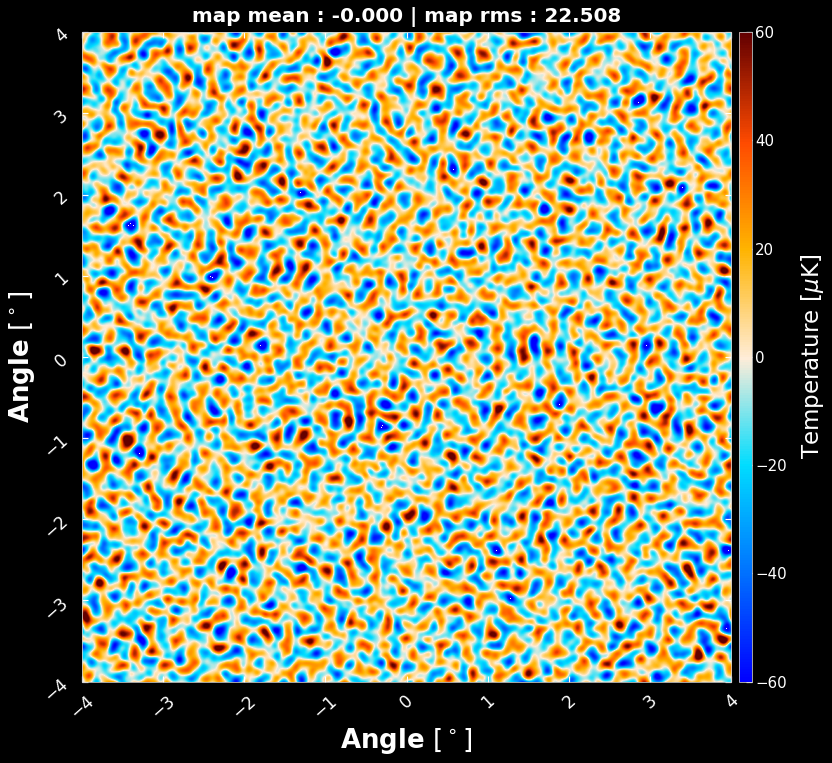

In [20]:
plot_CMB_map(CMB_I, X_width, Y_width, c_min=-60, c_max=60,
             save=False)

In [21]:
# Create the the 2D CMB simulated map in Fourier space, note the x and y axis labels need to be fixed
CMB_2D = np.real(np.conj(FT_2d) * FT_2d*ell2d * (ell2d+1) / (2*np.pi))

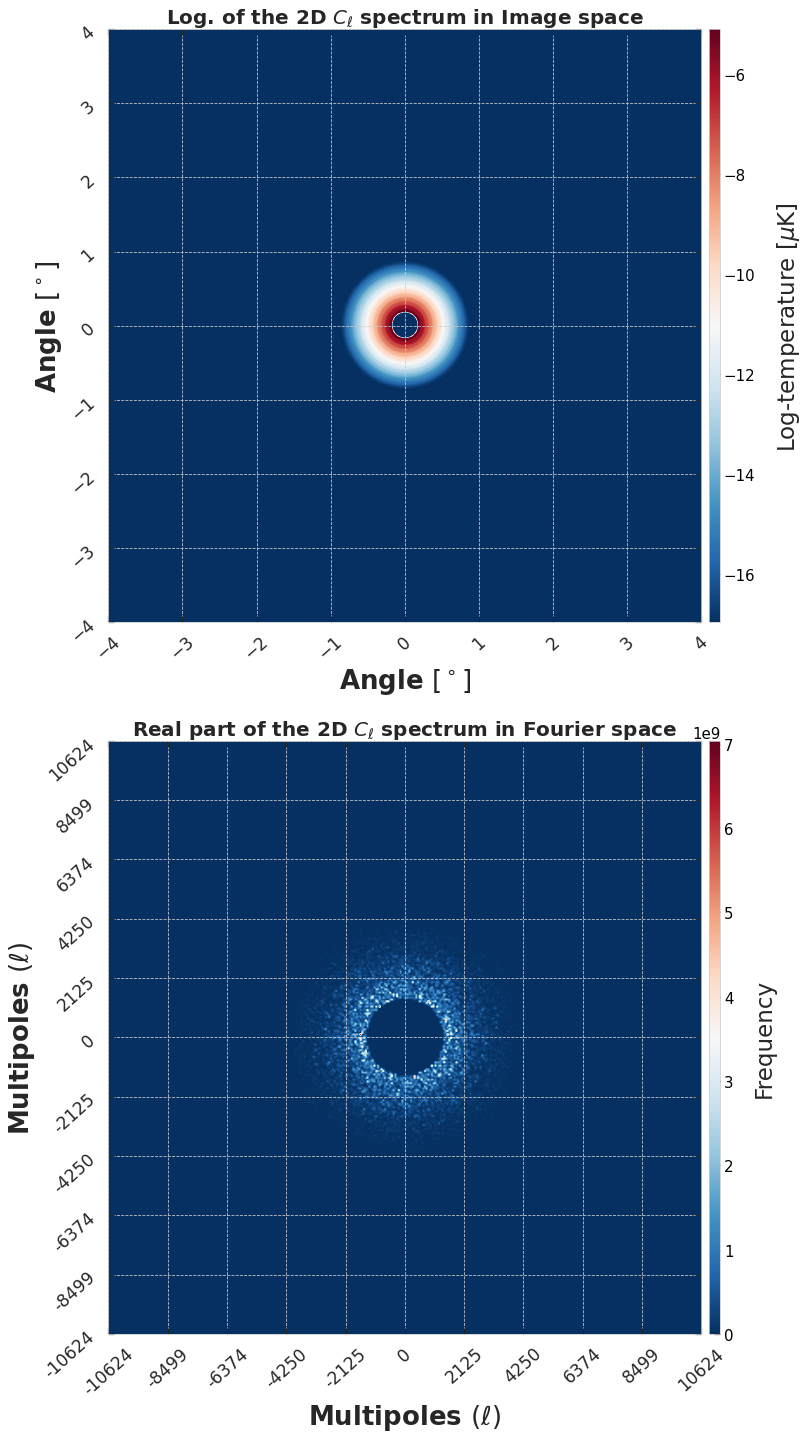

In [22]:
plot_CMB_steps(ell2d, ClTT2d, CMB_2D,
               X_width, Y_width,
               no_axis=False, no_grid=False)

### Cut spectrum above $\ell > 1000$

In [23]:
DlTT_ca = DlTT.copy()
DlTT_ca[ell > 1000] = 0
CMB_I, ell2d, ClTT2d, FT_2d = make_CMB_I_map(ell, DlTT_ca, N_x=N_x, N_y=N_y,
                                             X_width=X_width, Y_width=Y_width, pix_size=pix_size)

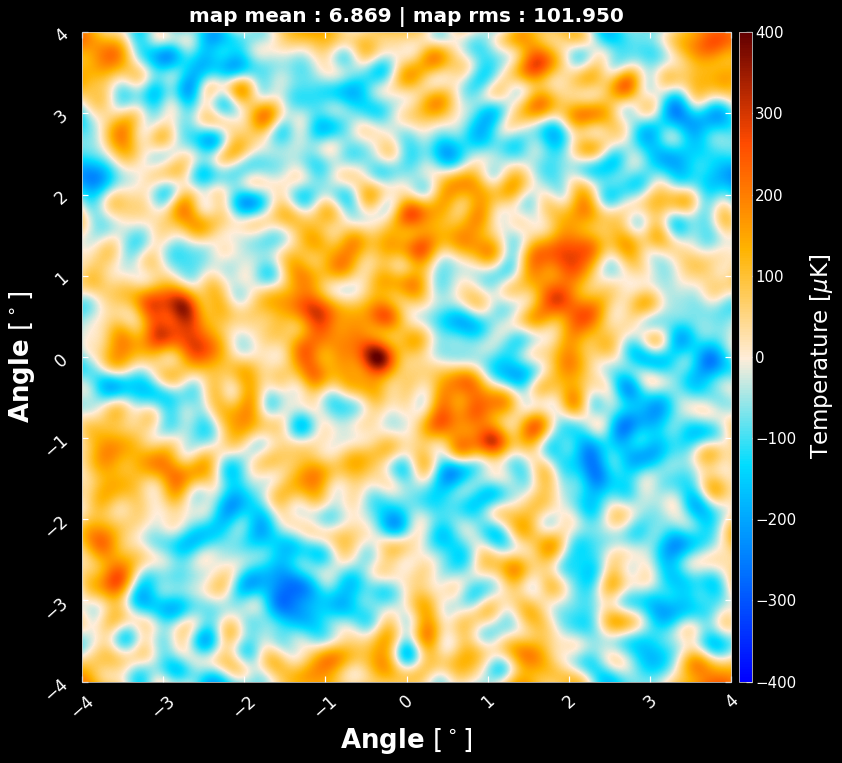

In [24]:
plot_CMB_map(CMB_I, X_width, Y_width, c_min=c_min, c_max=c_max,
             save=False)

In [25]:
# Create the the 2D CMB simulated map in Fourier space, note the x and y axis labels need to be fixed
CMB_2D = np.real(np.conj(FT_2d) * FT_2d*ell2d * (ell2d+1) / (2*np.pi))

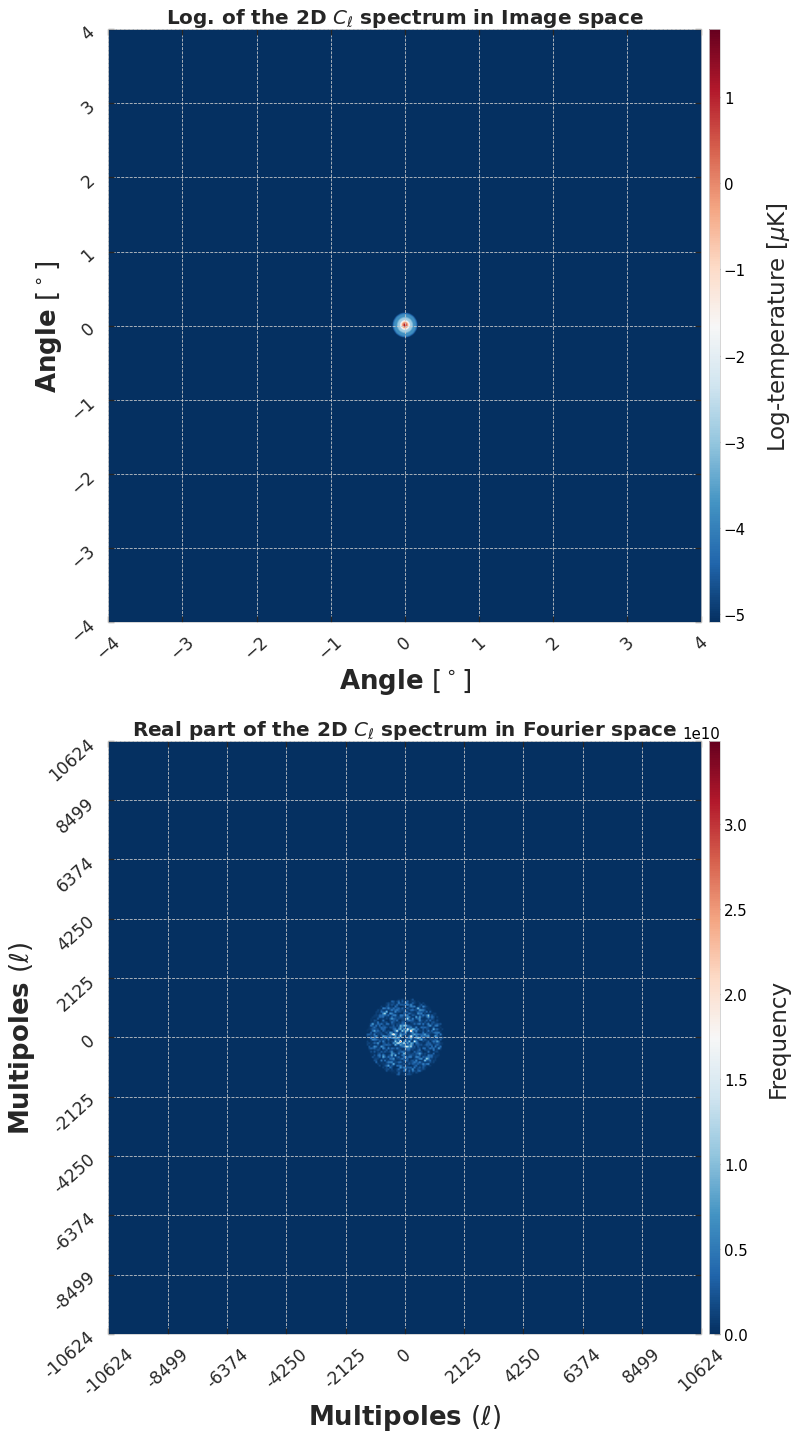

In [26]:
plot_CMB_steps(ell2d, ClTT2d, CMB_2D,
               X_width, Y_width,
               no_axis=False, no_grid=False)